**Project MET5** 
Lallu 
Jyoti
Ina
Magda

Burnt Areas in Burkina Faso

Import of libraries:

In [ ]:
import datacube
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import geopandas as gpd
from pyproj import Proj, transform
from datacube.utils.cog import write_cog
from odc.ui import with_ui_cbk

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.bandindices import calculate_indices

Create connection to WASCAL data cube with a unique app name.

In [ ]:
dc = datacube.Datacube(app="Burnt_area_mapping")

View List of Products in the Datacube

In [ ]:
dc.list_products()

Look up specifications of product

In [ ]:
product = "ls8_st"
measurements = dc.list_measurements()
measurements.loc[product]

Data availibility

landsat 8_sr data available every 16 days\
for January/February 2020: 01-07, 01-23, 02-08, 02-24

In [ ]:
from odc.ui import DcViewer

dcv = DcViewer(dc,time='2020-01-07', center=(12,1), zoom=6)
dcv

Display Research Area 




In [ ]:
from dea_tools.plotting import display_map
display_map([-4.00 ,-3.79],[11.75 ,11.36], crs = 'EPSG:4620')

In [ ]:
# Define the area of interest
lat = 11.69 #12.016
lon = -4.425 #-4.475
buffer = 0.1

# Compute the bounding box for the study area
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

Define Fire Period

In [77]:
start_date = '2017-10-01'
end_date='2017-12-01'
start_date_post ='2018-04-01'
end_date_post='2018-05-01'

In [ ]:
display_map(x=lon_range, y=lat_range)

In [68]:
# Define load parameters
resolution = (-30, 30)
measurements = ['blue', 'green', 'red',
                'nir', 'swir_1', 'swir_2', 'pixel_quality', 'radiometric_saturation']
#collection_category='T1'
min_gooddata = 0.6

In [78]:
# Choose the Landsat 8 products to load
products = ["ls8_sr"]

# Create a reusable query
query = {
    "x": lon_range,
    "y": lat_range,
    "resolution": resolution,
    "measurements": measurements
}

# Since this analysis calculates pixel areas,
# set the output projection to equal area projection EPSG:6933
output_crs = "EPSG:6933"

# Load all data in basline period avalible from ARD data
baseline_ard = load_ard(dc=dc,
                        products=products,
                        time=(start_date,end_date),
                        min_gooddata=min_gooddata,
                        output_crs=output_crs,
                        group_by='solar_day',
                        #collection_category=collection_category,
                        **query)

#Load data with DC
"""baseline_dc = dc.load(product=products,
                    output_crs=output_crs,
                     time=('2019-12-31', '2020-02-29'),
                     resampling=None,
                     skip_broken_datasets=False,
                     dask_chunks=None,
                     like=None,
                     fuse_func=None,
                     align=None,
                     datasets=None,
                     dataset_predicate=None,
                     progress_cbk=None,
                     **query)
                     """
                 

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr


/opt/conda/lib/python3.9/site-packages/deafrica_tools/datahandling.py:467: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  pq_mask = xr.ufuncs.logical_or(pq_mask, pq_mask)
/opt/conda/lib/python3.9/site-packages/xarray/core/dataarray.py:3086: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self.variable, other_variable)
/opt/conda/lib/python3.9/site-packages/xarray/core/variable.py:2429: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self_data, other_data) if not reflexive else f(other_data, self_data)


Counting good quality pixels for each time step
Filtering to 2 out of 4 time steps with at least 60.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 2 time steps


"baseline_dc = dc.load(product=products,\n                    output_crs=output_crs,\n                     time=('2019-12-31', '2020-02-29'),\n                     resampling=None,\n                     skip_broken_datasets=False,\n                     dask_chunks=None,\n                     like=None,\n                     fuse_func=None,\n                     align=None,\n                     datasets=None,\n                     dataset_predicate=None,\n                     progress_cbk=None,\n                     **query)\n                     "

In [ ]:
baseline_ard

In [ ]:
baseline_dc

# Calculate NBR\
In this part the Normalized Burn Ratio (NBR) is calculated to show the areas which have burned

In [79]:
# Calculate NBR for the baseline images
baseline_ard = calculate_indices(baseline_ard,
                                 index='NBR',
                                 collection='c2',
                                 drop=False)

# Compute median using all observations in the dataset along the time axis
baseline_image = baseline_ard.median(dim='time')
baseline_image_min = baseline_ard.min(dim='time')

# Select NBR
baseline_NBR = baseline_image.NBR
baseline_NBR_min = baseline_image_min.NBR



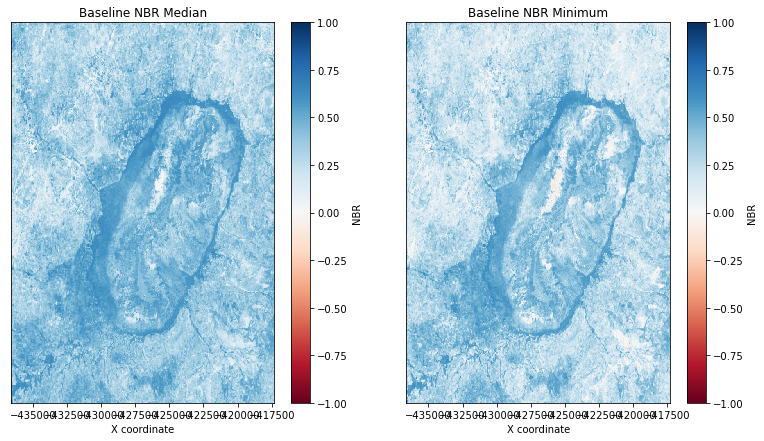

In [80]:
# Visualise baseline image as true colour image
"""f, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(13, 7))
rgb(baseline_image,
    bands=['red', 'green', 'blue'],
    ax=ax1)
ax1.set_title('Baseline RGB')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
plt.show()"""

# Set up subplots
f, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))


# Visualise baseline image as NBR image
baseline_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax2)
ax2.set_title('Baseline NBR Median')
ax2.yaxis.set_visible(False)
ax2.set_xlabel('X coordinate')

# Visualise baseline minimum image as NBR image
baseline_NBR_min.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax3)
ax3.set_title('Baseline NBR Minimum')
ax3.yaxis.set_visible(False)
ax3.set_xlabel('X coordinate')

plt.show()

## Post Fire Data
Load the post fire data for the deltaNBR, which is an image after the fire season has ended. We chose the month of June for this purpose.

In [81]:
# Load post-fire NRT data from Landsat 8
post_col =  load_ard(dc=dc,
                     products=products,
                     time=(start_date_post, end_date_post),
                     min_gooddata=min_gooddata,
                     output_crs=output_crs,
                     group_by='solar_day',
                     **query)


Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Counting good quality pixels for each time step


/opt/conda/lib/python3.9/site-packages/deafrica_tools/datahandling.py:467: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  pq_mask = xr.ufuncs.logical_or(pq_mask, pq_mask)
/opt/conda/lib/python3.9/site-packages/xarray/core/dataarray.py:3086: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self.variable, other_variable)
/opt/conda/lib/python3.9/site-packages/xarray/core/variable.py:2429: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self_data, other_data) if not reflexive else f(other_data, self_data)


Filtering to 1 out of 2 time steps with at least 60.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 1 time steps


In [63]:
post_col

<xarray.Dataset>
Dimensions:                 (time: 1, y: 834, x: 644)
Coordinates:
  * time                    (time) datetime64[ns] 2018-09-21T10:38:28.417907
  * y                       (y) float64 1.494e+06 1.494e+06 ... 1.469e+06
  * x                       (x) float64 -4.366e+05 -4.366e+05 ... -4.173e+05
    spatial_ref             int32 6933
Data variables:
    blue                    (time, y, x) float32 0.02973 0.03925 ... 0.03004
    green                   (time, y, x) float32 0.0745 0.0893 ... 0.06859
    red                     (time, y, x) float32 0.06636 0.105 ... 0.06433
    nir                     (time, y, x) float32 0.3793 0.3487 ... 0.2522 0.2922
    swir_1                  (time, y, x) float32 0.2314 0.2943 ... 0.2235 0.2079
    swir_2                  (time, y, x) float32 0.1381 0.1981 ... 0.1258 0.1092
    pixel_quality           (time, y, x) uint16 21824 21824 ... 21824 21824
    radiometric_saturation  (time, y, x) uint16 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

## Generate NBR for Post fire Image

In [82]:
# Calculate NBR on all post-fire images
post_combined = calculate_indices(post_col, index='NBR', collection='c2', drop=False)

# Calculate the median post-fire image
post_image = post_combined.median(dim='time')

# Select NBR
post_NBR = post_image.NBR
post_NBR

<xarray.DataArray 'NBR' (y: 834, x: 644)>
array([[ 0.07894208,  0.0204623 , -0.01682981, ...,  0.06993556,
         0.05344813,  0.03224888],
       [ 0.07894208,  0.0204623 , -0.01682981, ...,  0.03791605,
         0.02036845,  0.00937596],
       [ 0.02265292, -0.01477634, -0.02624476, ...,  0.0359518 ,
         0.01157258,  0.00897868],
       ...,
       [        nan,         nan,         nan, ...,  0.01549233,
         0.03330316,  0.02843676],
       [        nan,         nan,         nan, ...,  0.01549233,
         0.03330316,  0.02843676],
       [        nan,         nan,         nan, ...,  0.00160846,
         0.02815792,  0.02797429]], dtype=float32)
Coordinates:
  * y            (y) float64 1.494e+06 1.494e+06 ... 1.469e+06 1.469e+06
  * x            (x) float64 -4.366e+05 -4.366e+05 ... -4.173e+05 -4.173e+05
    spatial_ref  int32 6933

In [83]:
### Use a single image:

# Select the most recent image after the fire
post_image = post_col.isel(time=0)

# Calculate NBR
post_image = calculate_indices(post_image, index='NBR', collection='c2', drop=False)

# Select NBR
post_NBR = post_image.NBR

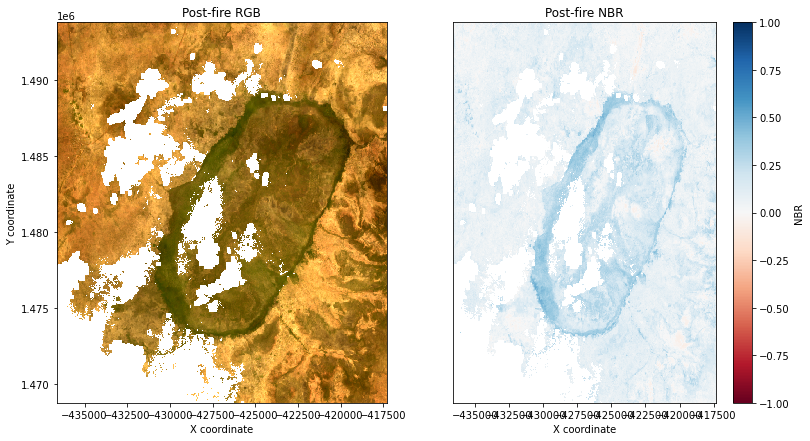

In [84]:
 #Set up subplots
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))

# Visualise post-fire image as true colour image
rgb(post_image,
    bands=['red', 'green', 'blue'],
    ax=ax1)
ax1.set_title('Post-fire RGB')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')

# Visualise post-fire image as NBR image
post_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax2)
ax2.set_title('Post-fire NBR')
ax2.yaxis.set_visible(False)
ax2.set_xlabel('X coordinate')

plt.show()

Calculate Delta Normalized Burn Ratio

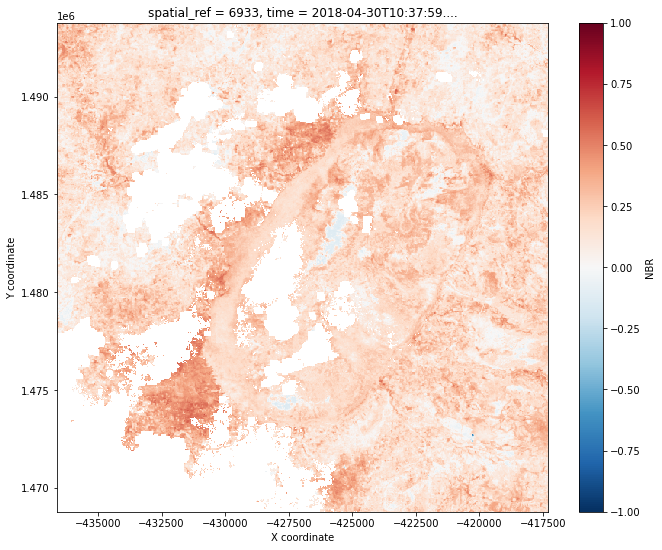

In [85]:
delta_NBR = baseline_NBR_min - post_NBR

# Visualise dNBR image
delta_NBR.plot(cmap='RdBu_r', vmin=-1, vmax=1, figsize=(11, 9))
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

plt.show()



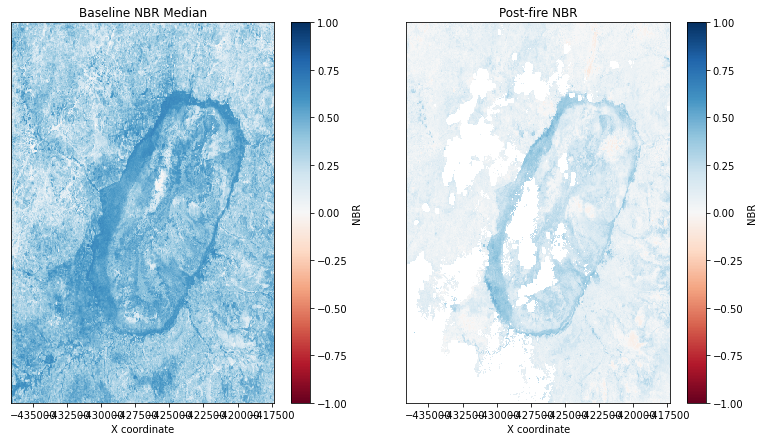

In [86]:
 #Set up subplots
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))

# Visualise post-fire image as true colour image
baseline_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax1)
ax1.set_title('Baseline NBR Median')
ax1.yaxis.set_visible(False)
ax1.set_xlabel('X coordinate')

# Visualise post-fire image as NBR image
post_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax2)
ax2.set_title('Post-fire NBR')
ax2.yaxis.set_visible(False)
ax2.set_xlabel('X coordinate')

plt.show()

# Apply Threshold to Delta NBR

In [87]:
# Set threshold
threshold = 0.3

# Apply threshold
burnt = delta_NBR > threshold

# Mask post-fire true colour image
masked = delta_NBR.where(burnt==1)



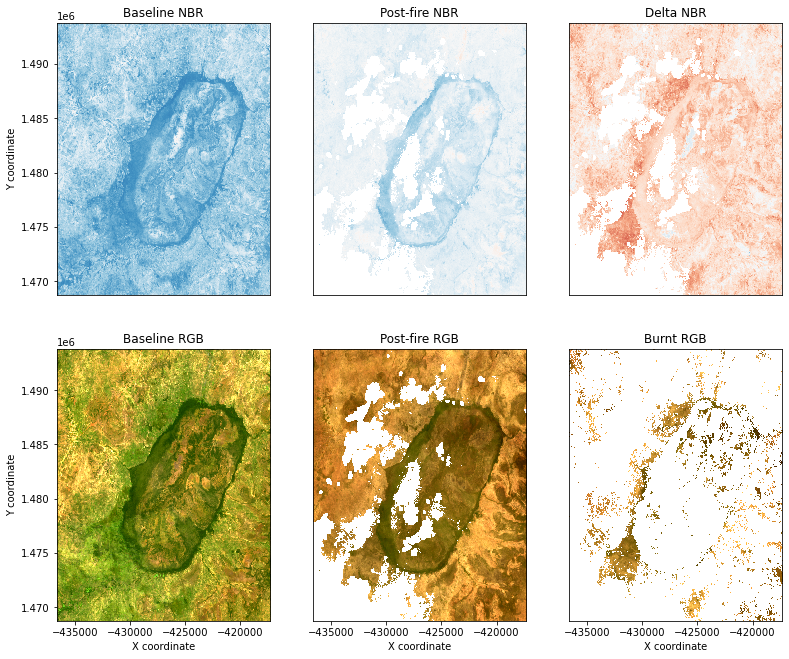

In [88]:
# Set up subplots
f, axarr = plt.subplots(2, 3, figsize=(13, 11))
bands=['red', 'green', 'blue']

baseline_NBR.plot(cmap='RdBu', vmin=-1, vmax=1,
                  add_colorbar=False, ax=axarr[0, 0])
axarr[0, 0].set_title('Baseline NBR')
axarr[0, 0].set_ylabel('Y coordinate')
axarr[0, 0].xaxis.set_visible(False)

post_NBR.plot(cmap='RdBu', vmin=-1, vmax=1,
              add_colorbar=False, ax=axarr[0, 1])
axarr[0, 1].set_title('Post-fire NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].xaxis.set_visible(False)

delta_NBR.plot(cmap='RdBu_r', vmin=-1, vmax=1,
               add_colorbar=False, ax=axarr[0, 2])
axarr[0, 2].set_title('Delta NBR')
axarr[0, 2].yaxis.set_visible(False)
axarr[0, 2].xaxis.set_visible(False)

rgb(baseline_image, bands=bands, ax=axarr[1, 0])
axarr[1, 0].set_title('Baseline RGB')
axarr[1, 0].set_title('Baseline RGB')
axarr[1, 0].set_xlabel('X coordinate')
axarr[1, 0].set_ylabel('Y coordinate')

rgb(post_image, bands=bands, ax=axarr[1,1])
axarr[1, 1].set_title('Post-fire RGB')
axarr[1, 1].set_xlabel('X coordinate')
axarr[1, 1].yaxis.set_visible(False)

rgb(post_image.where(burnt==1), bands=bands, ax=axarr[1, 2])
axarr[1, 2].set_title('Burnt RGB')
axarr[1, 2].set_xlabel('X coordinate')
axarr[1, 2].yaxis.set_visible(False)

## Calculate area burnt

In [89]:
# Constants for calculating burnt area
pixel_length = resolution[1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres

# Area per pixel
area_per_pixel = pixel_length ** 2 / m_per_km ** 2

# Calculate areas
unburnt_area = (delta_NBR <= threshold).sum() * area_per_pixel
burnt_area = burnt.sum() * area_per_pixel
not_nan_area = delta_NBR.notnull().sum() * area_per_pixel
nan_area = delta_NBR.isnull().sum() * area_per_pixel
total_area = unburnt_area + burnt_area + nan_area

print(f'Unburnt area:            {unburnt_area.item():.2f} km^2')
print(f'Burnt area:              {burnt_area.item():.2f} km^2')
print(f'Nan area:                {nan_area.item():.2f} km^2')
print(f'Total area (no nans):    {not_nan_area.item():.2f} km^2')
print(f'Total area (with nans):  {total_area.item():.2f} km^2')
print()
print(f'Percentage of total area burnt: {100*burnt_area.item()/total_area.item():.2f}%')

Unburnt area:            329.12 km^2
Burnt area:              51.83 km^2
Nan area:                102.44 km^2
Total area (no nans):    380.95 km^2
Total area (with nans):  483.39 km^2

Percentage of total area burnt: 10.72%
